# CTRL+ALT+PLAY: Predictor de afición a Videojuegos

Nuestro proyecto busca entrenar una IA la cual nos ayude a hacer una estimación sobre una muestra de personas cuyo hobby son los videojuegos y cuanto tiempo dedican a esta actividad, la cual se puede aplicar en empresas dedicadas a esta industria para estimar cual podría ser el nivel de la aceptación y la posible distribución de los mismos en los proyectos en ejecución creando experiencias más adaptadas a sus usuarios.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ai-uis-student/plojecto/online_gaming_behavior_dataset.csv')

##Utils

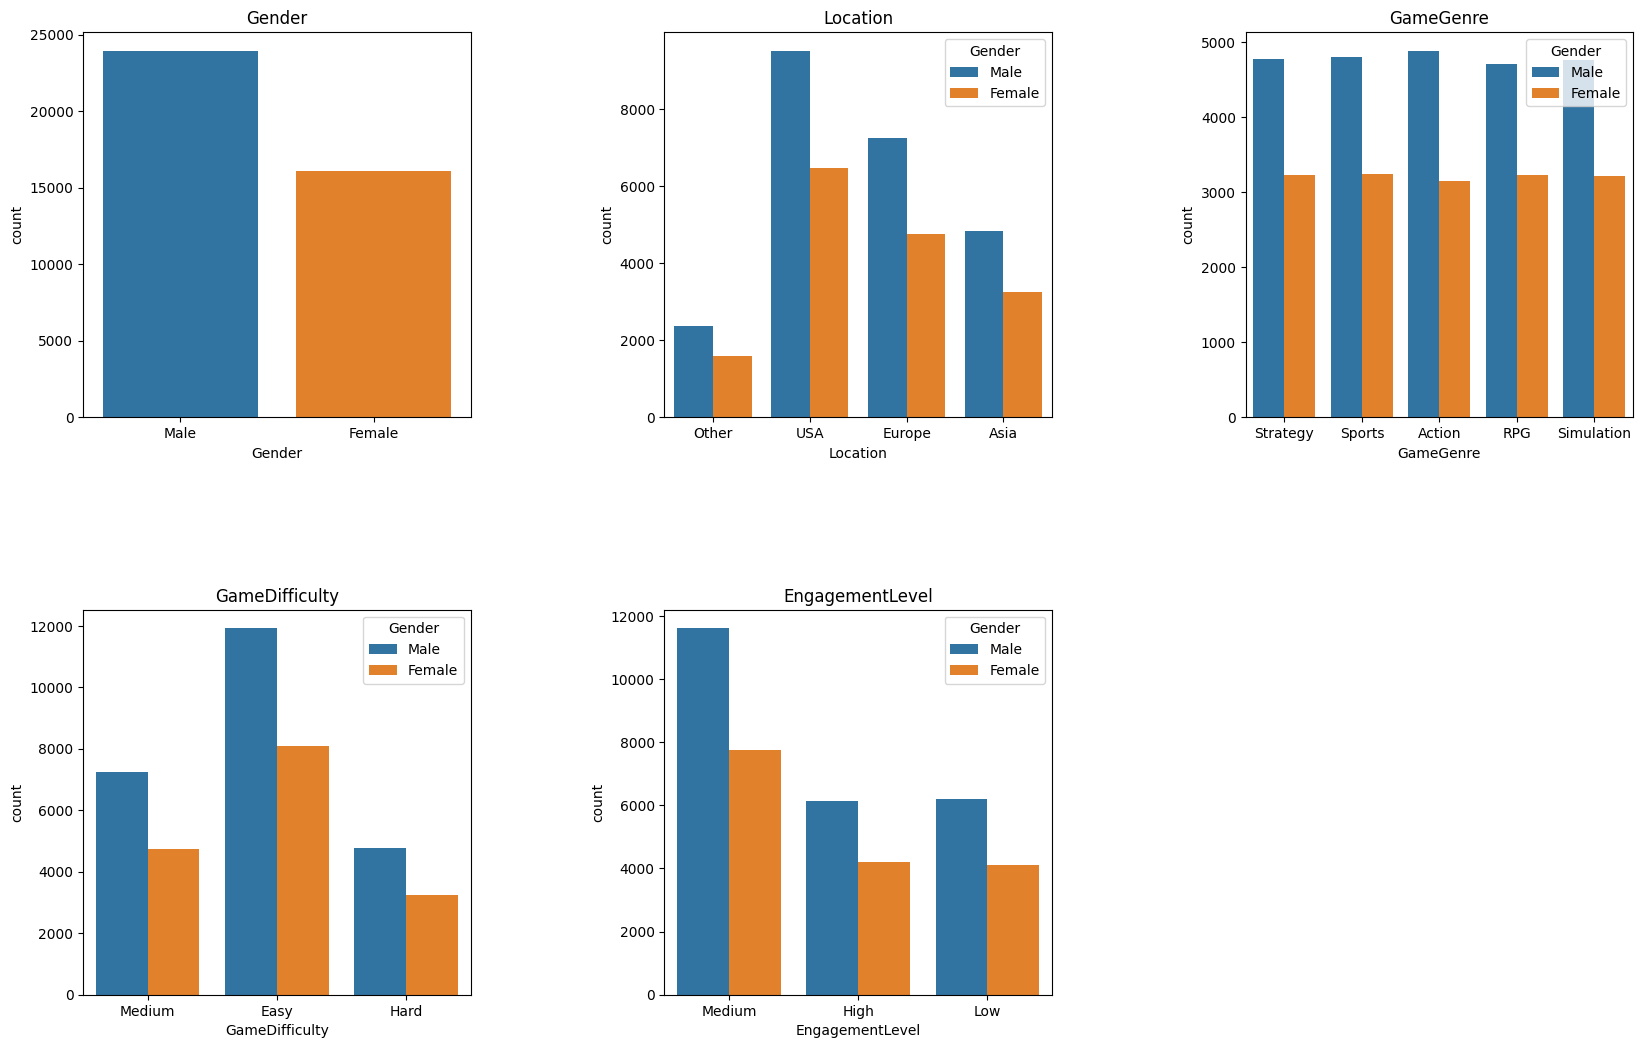

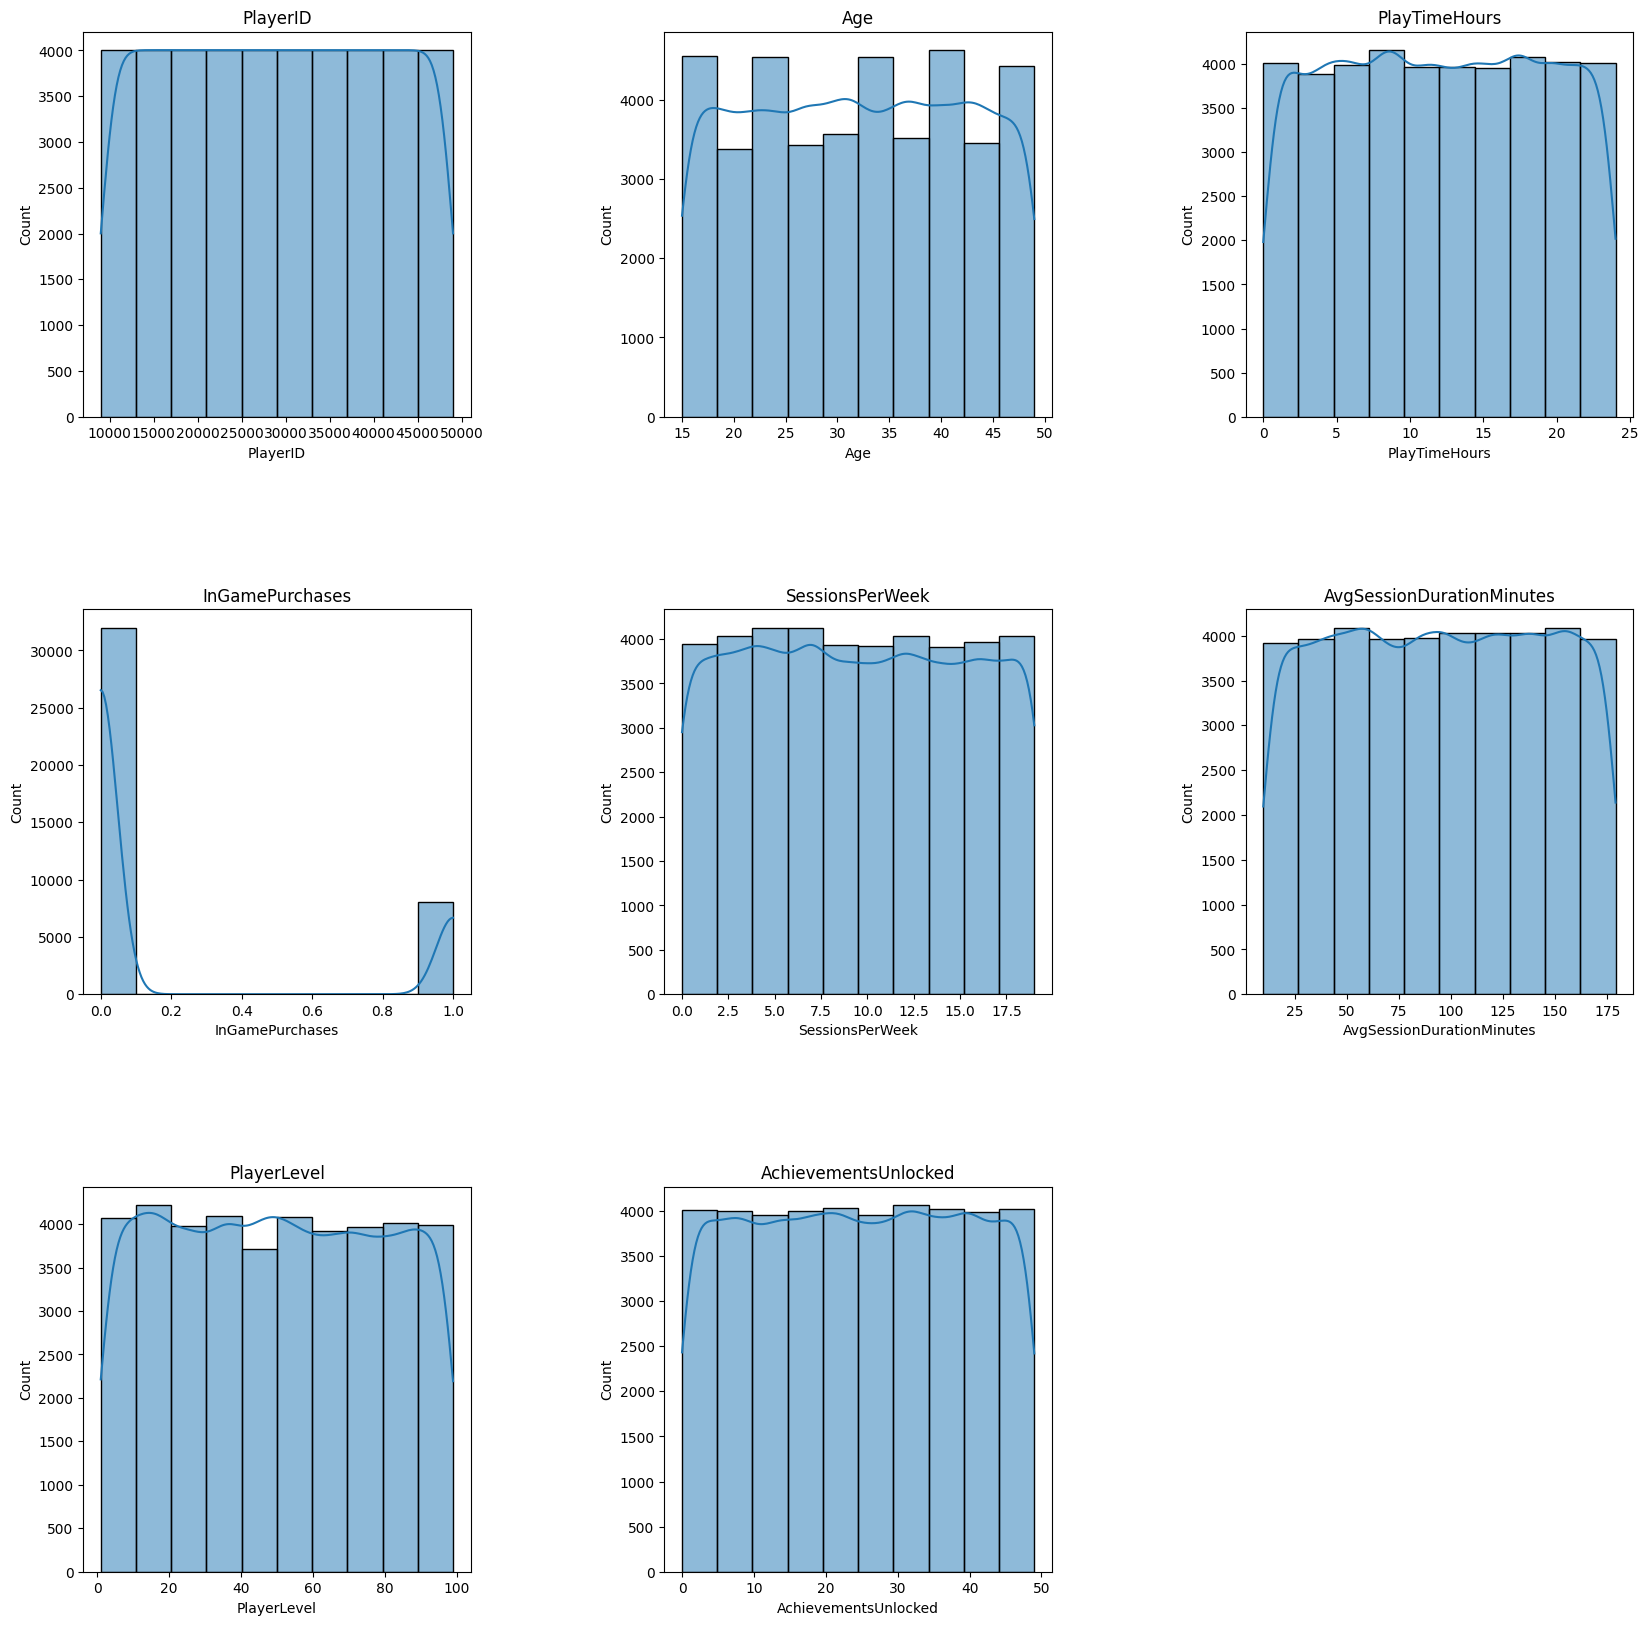

In [ ]:
def plot_grid(df, what='categorical'):
  """Plots all columns of a DataFrame in a square grid of subplots."""
  if what == 'categorical':
    df = df.select_dtypes(include=['object'])
  elif what == 'numerical':
    df = df.select_dtypes(include=['number'])
  num_cols = len(df.columns)
  grid_size = int(math.ceil(math.sqrt(num_cols)))

  fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))
  fig.subplots_adjust(hspace=0.5, wspace=0.5)

  for i, col in enumerate(df.columns):
    row = i // grid_size
    col_idx = i % grid_size
    ax = axes[row, col_idx]

    # Choose plot type based on data type
    if pd.api.types.is_numeric_dtype(df[col]):
      sns.histplot(df[col], ax=ax, bins=10, kde=True)
    else:
      sns.countplot(x=df[col], ax=ax, hue=df['Gender'])

    ax.set_title(col)

  # Hide any unused subplots
  for i in range(num_cols, grid_size * grid_size):
    row = i // grid_size
    col_idx = i % grid_size
    fig.delaxes(axes[row, col_idx])

  plt.show()

plot_grid(df, 'categorical')
plot_grid(df, 'numerical')


#Preprocesamiento

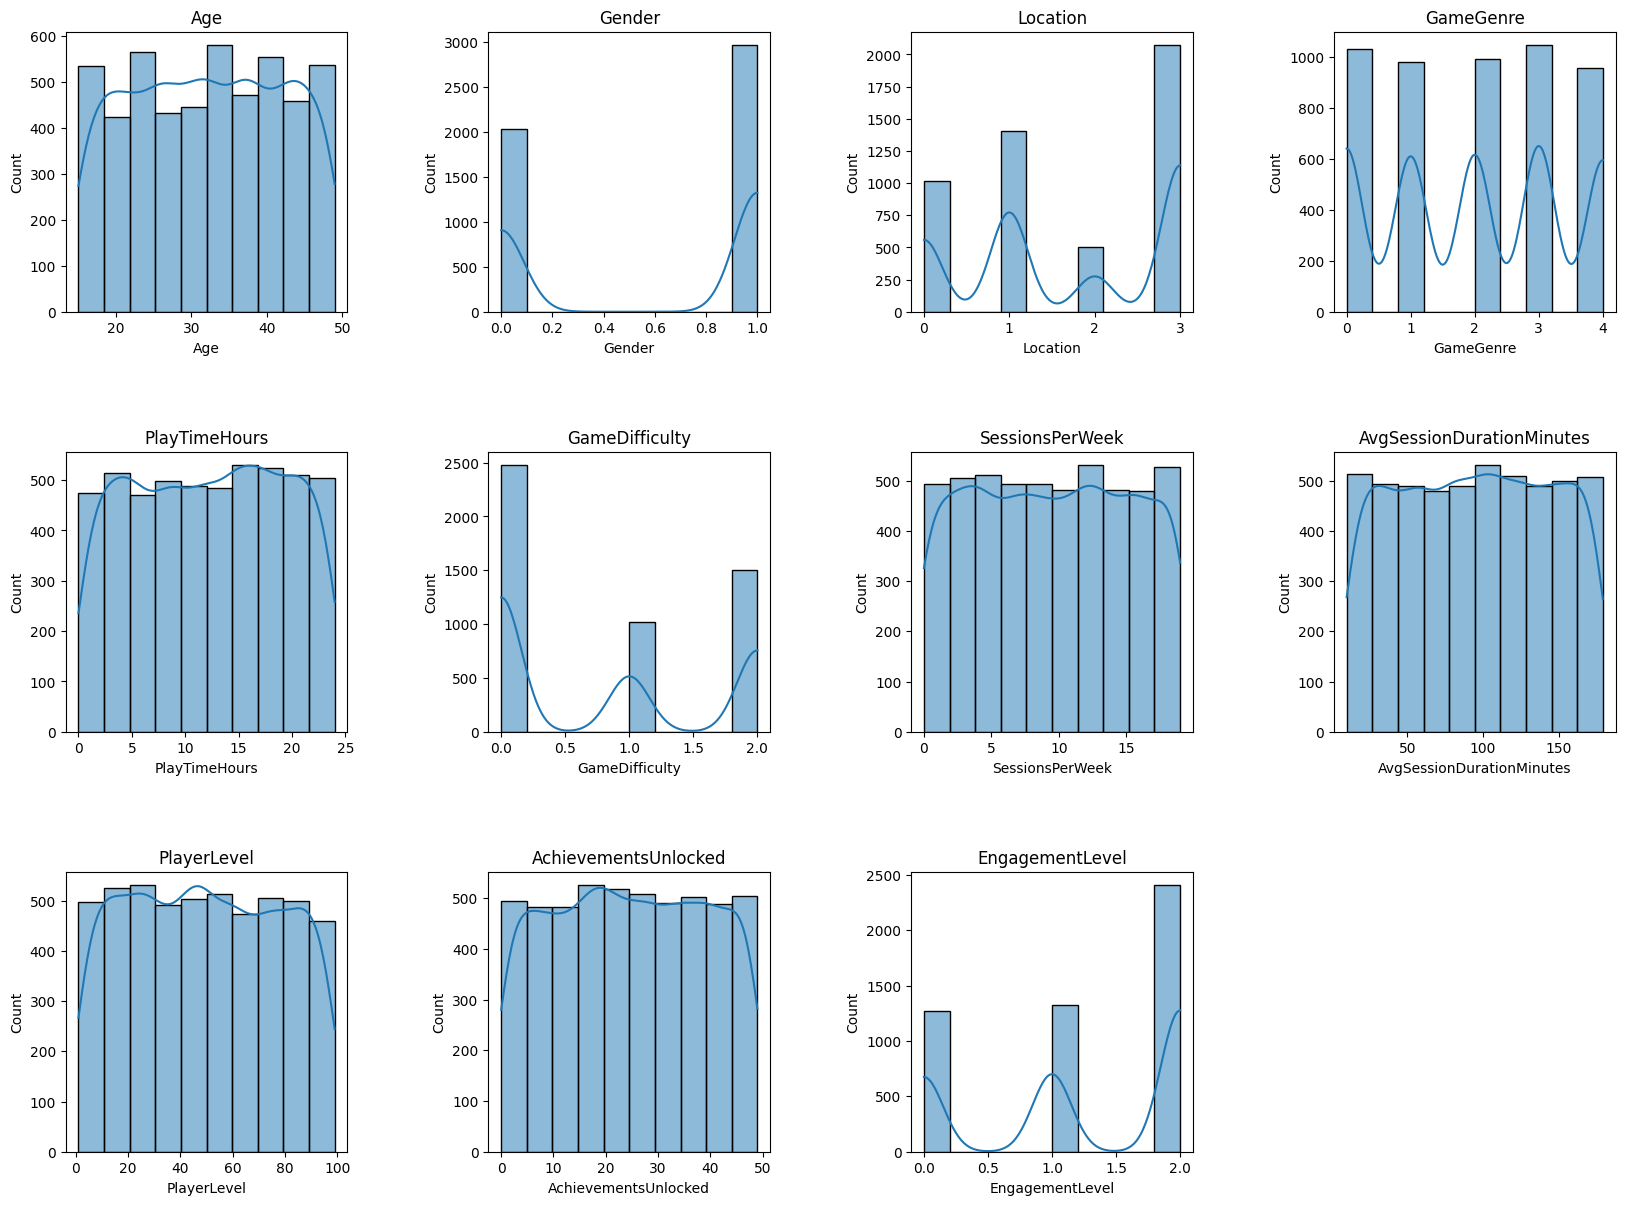

In [ ]:
# InGamePurchases es medio inutil, y tambien el PlayerID
df = df.drop(['InGamePurchases', 'PlayerID'], axis=1)
df.head()

#Convert categorical columns to numerical

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Iterate over the categorical columns and apply Label Encoding
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# Downsampling
sample_size = 5000
weights = np.random.normal(loc=0.5, scale=0.1, size=len(df))
weights = weights / weights.sum()
df = df.sample(n=sample_size, weights=weights, random_state=42)
plot_grid(df, 'numerical')

#Entrenamiento
<img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExdnphdnpiOG1zM3l2aG9lOHYyMzByOW5kNzVwaTlkODBwN3p3Z3dqeCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/hqTguNdEoA1ooYxeog/giphy.gif" width=320>

Nuestro proyecto es de regresion lineal asi que nuestro $y$ debe ser numerico (por eso se codificaron las columnas categoricas como numericas)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

x = df.drop('PlayTimeHours', axis=1)
y = df['PlayTimeHours']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #Particion 80/20

In [ ]:
def show_curve_crossval(est, ax):
    means, stds = [], []
    nfolds_range = range(2,10)
    for nfolds in nfolds_range:
        #print (nfolds,)
        s = cross_val_score(model, x, y, cv=KFold(nfolds, shuffle=True), scoring=make_scorer(mean_squared_error))
        means.append(np.mean(s))
        stds.append(np.std(s))

    means = np.r_[means]
    stds  = np.r_[stds]

    ax.plot(nfolds_range, means, label="mean", color="black")
    ax.fill_between(nfolds_range, means-stds, means+stds, color="blue", alpha=.5, label="std")
    ax.set_xlabel("n folds")
    ax.set_ylabel("performance")
    ax.legend()
    ax.grid(True)

In [ ]:
def show_curve_train_test(est, X_train, X_test, y_train, y_test, ax):
    stds, scores = [], []
    nfolds_range = range(10,101,10)

    for nfolds in range(10,101,10):

        if est == 'DecisionTreeRegressor':
            model = DecisionTreeRegressor(max_depth=nfolds)
        else:
          model = RandomForestRegressor(n_estimators=nfolds)

        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        scores.append(mean_squared_error(y_test, pred))
        stds.append(np.std(scores))

    stds  = np.r_[stds]
    scores = np.r_[scores]

    ax.plot(nfolds_range, scores, label="mean", color="black")
    ax.fill_between(nfolds_range, scores-stds, scores+stds, color="blue", alpha=.5, label="std")
    ax.set_xlabel("n estimators/max_depth")
    ax.set_ylabel("performance")
    ax.legend()
    ax.grid(True)

##Decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

model_d = DecisionTreeRegressor()
model_d.fit(x_train, y_train)
y_pred = model_d.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

cv_scores = cross_val_score(model_d, x, y, cv=3, scoring=make_scorer(mean_squared_error))

print("Mean Squared Error:", mse)
#print("Cross-Validation MSE (Media):", np.mean(cv_scores))
#print("Cross-Validation MSE (Desviación estándar):", np.std(cv_scores))


Mean Squared Error: 98.52538107082428


Axes(0.125,0.11;0.352273x0.77)


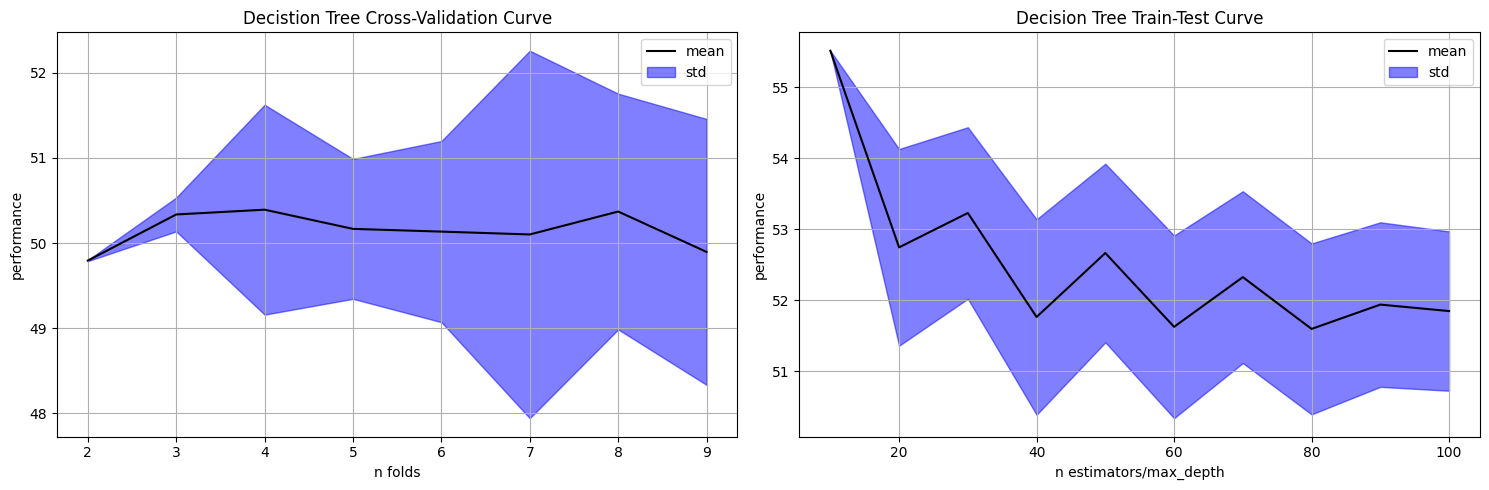

In [ ]:
# First curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
show_curve_crossval(DecisionTreeRegressor(), axes[0])
axes[0].set_title('Decision Tree Cross-Validation Curve')


# Second curve
show_curve_train_test('', x_train, x_test, y_train, y_test, axes[1])
axes[1].set_title('Decision Tree Train-Test Curve')

plt.tight_layout()
plt.savefig('DecisionTreeCurves.png', bbox_inches='tight')
plt.show()

##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

model_r = RandomForestRegressor()
model_r.fit(x_train, y_train)

y_pred = model_r.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

#cv_scores = cross_val_score(model, X, y, cv=3, scoring=make_scorer(mean_squared_error))

results = {
        'MSE (Prueba)': mse,
        'MAE (Prueba)': mae,
        'RMSE (Prueba)': rmse,
        #'Cross-Validation MSE (Media)': np.mean(cv_scores),
        #'Cross-Validation MSE (Desviación estándar)': np.std(cv_scores)
}

for key, value in results.items():
    print(f"{key}: {value:.4f}")

MSE (Prueba): 49.9110
MAE (Prueba): 6.0488
RMSE (Prueba): 7.0648


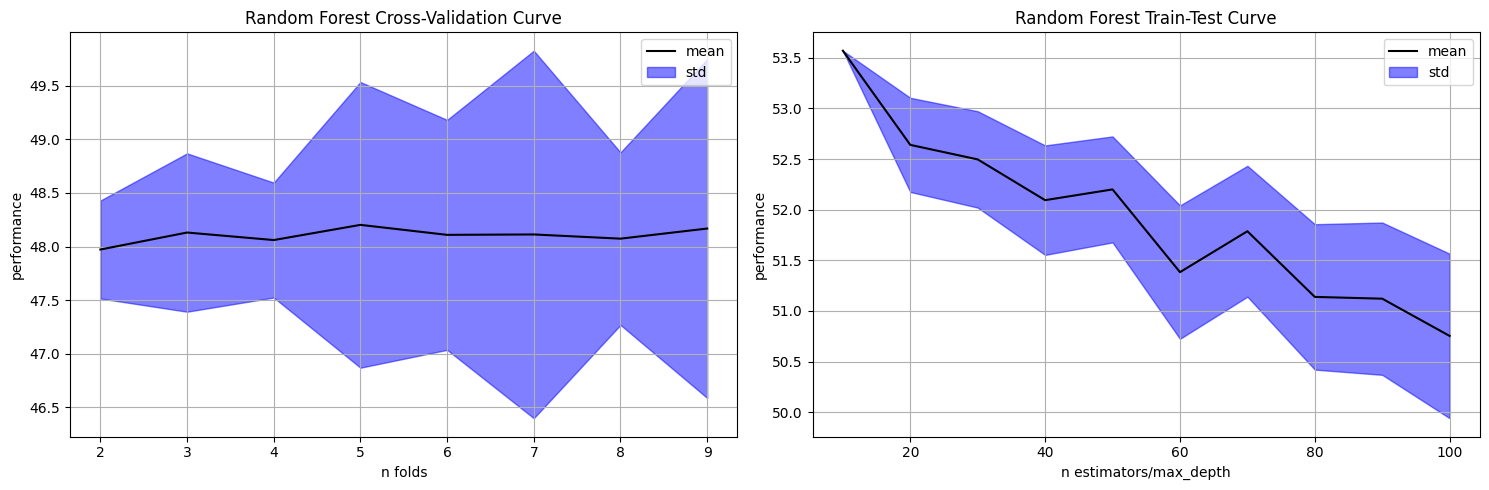

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# First curve
show_curve_crossval(RandomForestRegressor(), axes[0])
axes[0].set_title('Random Forest Cross-Validation Curve')

# Second curve
show_curve_train_test('', x_train, x_test, y_train, y_test, axes[1])
axes[1].set_title('Random Forest Train-Test Curve')

plt.tight_layout()
plt.savefig('RandomForestCurves.png', bbox_inches='tight')
plt.show()

##SVM

In [ ]:
from sklearn.svm import SVR

model_s = SVR()
model_s.fit(x_train, y_train)
y_pred = model_s.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 47.88671679541545


In [ ]:
#Barplots for kernels svr
def svr_plot(ax):
  kernels = ['linear', 'poly', 'rbf']
  mse_values = []

  for kernel in kernels:
      model = SVR(kernel=kernel)
      model.fit(x_train, y_train)
      y_pred = model.predict(x_test)
      mse = mean_squared_error(y_test, y_pred)
      mse_values.append(mse)

  bars = ax.bar(kernels, mse_values)
  for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
  ax.set_xlabel('Kernel')
  ax.set_ylabel('Mean Squared Error')

#svr_plot()

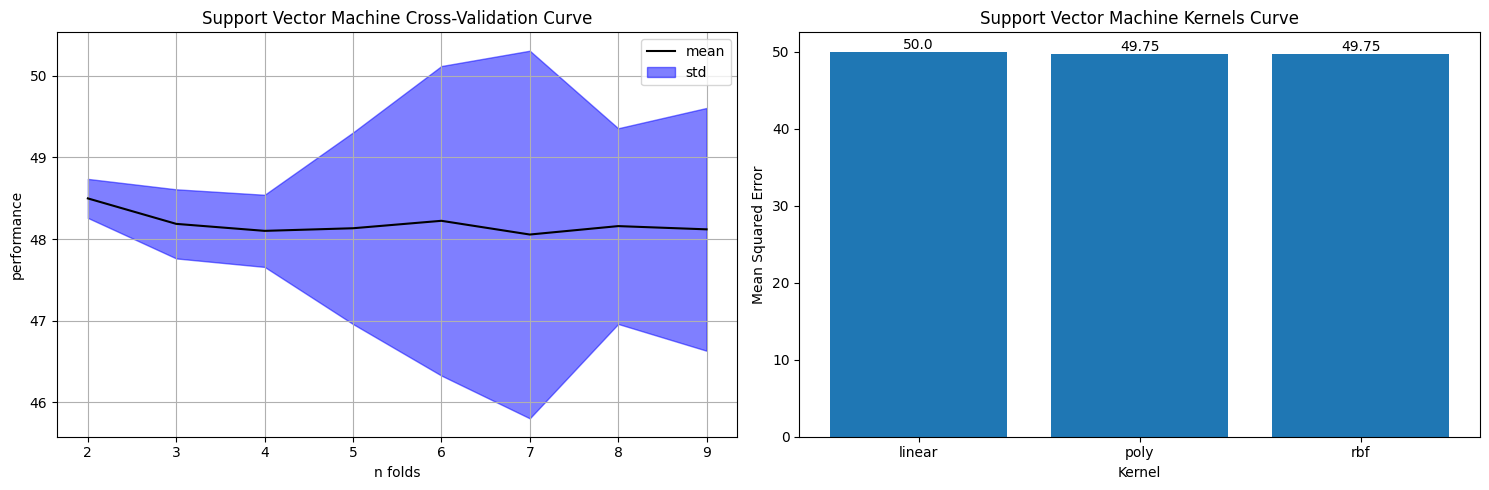

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# First curve
show_curve_crossval(SVR(), axes[0])
axes[0].set_title('Support Vector Machine Cross-Validation Curve')

# Second curve
svr_plot(axes[1])
axes[1].set_title('Support Vector Machine Kernels Curve')

plt.tight_layout()
plt.savefig('SVMPlots.png', bbox_inches='tight')
plt.show()

In [ ]:
new_data = pd.DataFrame({
    'Age': [60],
    'Gender': [1],
    'Location': [0],
    'GameGenre': [2],
    'GameDifficulty': [1],
    'SessionsPerWeek': [4],
    'AvgSessionDurationMinutes':[30],
    'PlayerLevel':[50],
    'AchievementsUnlocked':[10],
    'EngagementLevel':[1]
})

new_prediction = model.predict(new_data)
print("Prediction:", new_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction: [[12.623099]]


## Perceptron

In [ ]:
import tensorflow as tf
from tensorflow import keras

# El ground truth, x y los datos de entrenamiento con proporción del 80%
# para entrenamiento y 20% para prueba, ya estan definidos anteriormente.

# 3 capas

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(), loss='crossentropy', metrics=['mae'])
model.fit(x_train, y_train, epochs=10, verbose=1)
y_pred = model.predict(x_test, verbose=1)

test_loss, test_mae_3 = model.evaluate(x_test, y_test)
print('Test MAE para 3 capas:', test_mae_3)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -178.2305 - mae: 6.7895
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -177.3791 - mae: 6.7092
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -177.1672 - mae: 6.7481
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -178.7828 - mae: 6.8426
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -181.0501 - mae: 6.7509
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -177.9016 - mae: 6.7616
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -180.1045 - mae: 6.6517
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -179.9219 - mae: 6.7328
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -179.5691 - mae: 6.6782
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -181.8743 - mae: 6.7426
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -173.9229 - mae: 6.8938  
Test MAE para 3 capas: 6.910581588745117


In [ ]:
# 6 capas
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(), loss='crossentropy', metrics=['mae'])
model.fit(x_train, y_train, epochs=10, verbose=1)
y_pred = model.predict(x_test, verbose=1)

test_loss, test_mae_6 = model.evaluate(x_test, y_test)
print('Test MAE para 6 capas:', test_mae_6)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: -176.3991 - mae: 149196.0469
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: -176.6539 - mae: 156282.9688
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: -181.7803 - mae: 156260.7500
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: -178.0478 - mae: 157233.5781
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: -180.2329 - mae: 156385.6719
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: -177.1699 - mae: 156049.0312
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: -182.9816 - mae: 155715.9219
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: -178.1842 - mae: 155766.4062
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: -177.6735 - mae: 156483.4531
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: -173.8258 - mae: 155271.1406
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -173.9229 - mae: 154199.

In [ ]:
# 10 capas
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(), loss='crossentropy', metrics=['mae'])
model.fit(x_train, y_train, epochs=10, verbose=1)
y_pred = model.predict(x_test, verbose=1)

test_loss, test_mae_10 = model.evaluate(x_test, y_test)
print('Test MAE para 10 capas:', test_mae_10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: -172.0523 - mae: 19004.9746
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: -181.3398 - mae: 19866.4297
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: -179.5995 - mae: 19597.6758
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: -179.2665 - mae: 19813.4551
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: -176.9705 - mae: 19762.4082
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: -179.8634 - mae: 19692.3730
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: -179.1129 - mae: 19390.9727
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: -178.9785 - mae: 19549.8633
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: -178.2981 - mae: 19771.0723
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: -177.9176 - mae: 19794.2188
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: -173.9229 - mae: 19075.2207
Test M

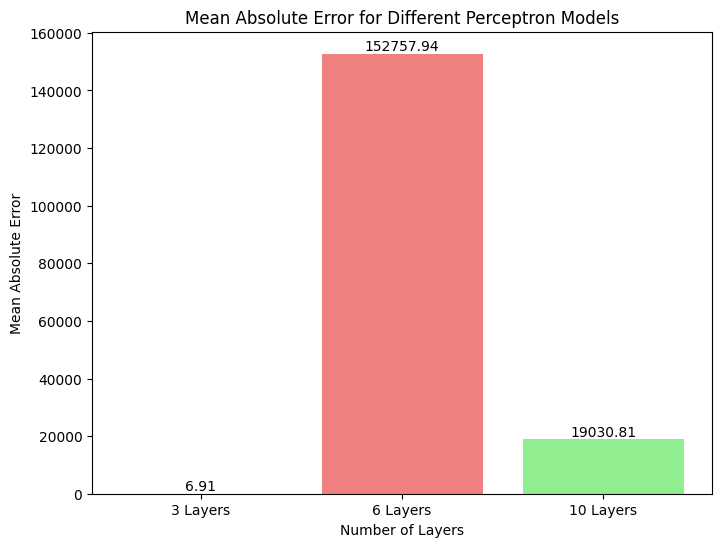

In [ ]:
mae_values = [test_mae_3, test_mae_6, test_mae_10]
model_names = ['3 Layers', '6 Layers', '10 Layers']

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, mae_values, color=['skyblue', 'lightcoral', 'lightgreen'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.xlabel("Number of Layers")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Error for Different Perceptron Models")
plt.show()

In [ ]:
new_data = pd.DataFrame({
    'Age': [60],
    'Gender': [1],
    'Location': [0],
    'GameGenre': [2],
    'GameDifficulty': [1],
    'SessionsPerWeek': [4],
    'AvgSessionDurationMinutes':[30],
    'PlayerLevel':[50],
    'AchievementsUnlocked':[10],
    'EngagementLevel':[1]
})

new_prediction = model.predict(new_data)
new_prediction_model_d = model_d.predict(new_data)
new_prediction_model_r = model_r.predict(new_data)
new_prediction_model_s = model_s.predict(new_data)
print("Prediction Decision Tree:", new_prediction_model_d)
print("Prediction Random Forest:", new_prediction_model_r)
print("Prediction SVM:", new_prediction_model_s)
print("Prediction Perceptron:", new_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction Decision Tree: [18.70984543]
Prediction Random Forest: [11.79902756]
Prediction SVM: [12.7118226]
Prediction Perceptron: [[12.623099]]


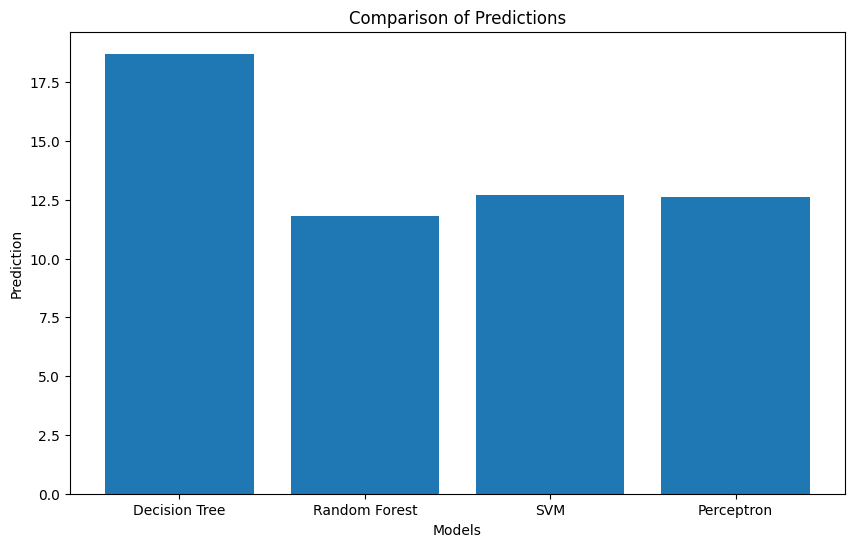

In [ ]:
plt.figure(figsize=(10, 6))
models = ['Decision Tree', 'Random Forest', 'SVM', 'Perceptron']
predictions = [new_prediction_model_d[0], new_prediction_model_r[0], new_prediction_model_s[0], new_prediction[0][0]]
plt.bar(models, predictions)
plt.xlabel("Models")
plt.ylabel("Prediction")
plt.title("Comparison of Predictions")
plt.show()